# Exploring Filecoin Deals 

Storage deals are core to Filecoin. They are the [main mechanism by which clients and storage providers interact](https://filecoin.io/blog/posts/how-storage-and-retrieval-deals-work-on-filecoin/). 

Let's explore the data!

## Data Sources

Deals data is available on-chain (via the [`StateMarketDeals`](https://lotus.filecoin.io/reference/lotus/state/#statemarketdeals) JSON-RPC method). 

Alternatively you can use an [oracle like `fil-naive-marketwatch`](https://github.com/ribasushi/fil-naive-marketwatch), rely on APIs like [Spacescope](https://spacescope.io/) for aggregated data or reconstruct the deals from [Lily](https://lilium.sh/) CSV dumps

I'll rely on [Glif nodes](https://lotus.filecoin.io/lotus/developers/glif-nodes/) export of `StateMarketDeals` on S3 ([direct link](https://marketdeals.s3.amazonaws.com/StateMarketDeals.json.zst)). 

In [2]:
import urllib
import zstandard
import ijson
import json

STATE_MARKET_DEALS_URL = (
    "https://marketdeals.s3.amazonaws.com/StateMarketDeals.json.zst"
)

# Download the file
urllib.request.urlretrieve(
    STATE_MARKET_DEALS_URL,
    "/tmp/StateMarketDeals.json.zst",
)

# Decompress the file
dctx = zstandard.ZstdDecompressor()
with open("/tmp/StateMarketDeals.json.zst", "rb") as fh:
    stream_reader = dctx.stream_reader(fh)
    output = stream_reader.read()
    with open("/tmp/StateMarketDeals.json", "wb") as f:
        f.write(output)

# Parse the file
with open("/tmp/ParsedStateMarketDeals.json", "w") as f:
    for k, v in ijson.kvitems(open("/tmp/StateMarketDeals.json"), ""):
        v["DealID"] = k
        f.write(json.dumps(v) + "\n")


Something similar can be done in `jq` with:

```bash
jq --stream 'fromstream(1|truncate_stream(inputs))' -c StateMarketDeals.json
```

Now we have a large JSON file with all the deals on-chain!

In [3]:
import duckdb

con = duckdb.connect(database="/tmp/database.duckdb", read_only=False)

con.execute(
    """
    select DealID, Proposal.*, State.* from read_ndjson_auto("/tmp/ParsedStateMarketDeals.json") limit 10
    """
).df()


,DealID,PieceCID,PieceSize,VerifiedDeal,Client,Provider,Label,StartEpoch,EndEpoch,StoragePricePerEpoch,ProviderCollateral,ClientCollateral,SectorStartEpoch,LastUpdatedEpoch,SlashEpoch,VerifiedClaim
0,159155,{'/': 'baga6ea4seaqaazz4brpn3zde6dkorq3muck42q...,65536,False,f020319,f016305,mAXESINiz1A6zzmVo8QoU7wKbP+gB3PGSyA43a4ZukzHIxc3z,1281643200,1282165340,0,0,0,-1,-1,-1,0
1,159170,{'/': 'baga6ea4seaqaazz4brpn3zde6dkorq3muck42q...,65536,False,f020319,f016305,mAXESINiz1A6zzmVo8QoU7wKbP+gB3PGSyA43a4ZukzHIxc3z,1282046400,1282568540,0,0,0,-1,-1,-1,0
2,159181,{'/': 'baga6ea4seaqaazz4brpn3zde6dkorq3muck42q...,65536,False,f020319,f016309,mAXESINiz1A6zzmVo8QoU7wKbP+gB3PGSyA43a4ZukzHIxc3z,1282608000,1283129618,0,0,0,-1,-1,-1,0
3,159183,{'/': 'baga6ea4seaqcjw5o3bbrn6u2tgv7j7lihxufsm...,1048576,False,f020319,f016305,mAXESIN6mq1OV8vx3Wq/vL7IaZX5f+bmEIatiFHnvR4ZNhLVr,1282608000,1283130140,0,0,0,-1,-1,-1,0
4,159188,{'/': 'baga6ea4seaqkkyehwbcfh6l72e2jrooyqvbbr6...,4096,False,f020319,f016304,mAXESIOBDGaYV/UAiPSsJZDXHqoU4SYqq7nJ0/tagst+ls8d9,1282680000,1283202204,0,0,0,-1,-1,-1,0
5,159189,{'/': 'baga6ea4seaqojxopcje7y4biwj3qs2xt3srmci...,4096,False,f020319,f016305,mAXESIAjeNqjrNMiI9wdUEG54r2AaDGf1WfvfXjuutGQ/esch,1282680000,1283202140,0,0,0,-1,-1,-1,0
6,159190,{'/': 'baga6ea4seaqpg2hxv5os6bygcipqks537txiao...,4096,False,f020319,f016303,mAXESIKtGtBrFsswfb5KZRnLb06BxpxE2ZJiuTQjWwUEy4dT5,1282680000,1283204137,0,0,0,-1,-1,-1,0
7,159191,{'/': 'baga6ea4seaqoxyynqy3cbeutvbiygtlk6jw6wc...,4096,False,f020319,f016309,mAXESIFcZ1jlnoL7/DPtkuvcTlV0aYMyeLo5YL5ivYcTLf+lj,1282680000,1283201618,0,0,0,-1,-1,-1,0
8,159192,{'/': 'baga6ea4seaqgxbzhjoaxjpzcqozmb6nznm6y45...,4096,False,f020319,f016303,mAXESIFvyl9nFfaMUEQ2XoY8SDTnhpybAFU/hcn98nkyQnVl6,1282680000,1283204137,0,0,0,-1,-1,-1,0
9,159193,{'/': 'baga6ea4seaqkwr7zajmbufki6sgx2f3cqcjbq3...,8192,False,f020319,f016309,mAXESIHyfVbyMVkTSYC2mCSewpvokw5I8LEBwQuwEvTsvAios,1282694400,1283216018,0,0,0,-1,-1,-1,0


In [5]:
_ = con.execute(
    """
    create or replace table state_market_deals as (
        select DealID, Proposal.*, State.* from read_ndjson_auto("/tmp/ParsedStateMarketDeals.json")
    )
    """
)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [8]:
con.sql(
    """
    select 
        sum(PieceSize) / 1024 ** 5 as total_pibs_in_active_deals,
    from state_market_deals
    where SectorStartEpoch > 0
    """
)


┌────────────────────────────┐
│ total_pibs_in_active_deals │
│           double           │
├────────────────────────────┤
│         1098.3741609410454 │
└────────────────────────────┘

In [5]:
df = con.sql(
    """
    select 
        DealID,
        StartEpoch,
        SectorStartEpoch,
        StartEpoch - SectorStartEpoch as SectorStartLag,
    from state_market_deals
    where SectorStartEpoch > 0
    """
).df()


count    3.640997e+07
mean     1.564203e+04
std      8.290045e+03
min      0.000000e+00
25%      1.258900e+04
50%      1.364600e+04
75%      1.799200e+04
max      2.580400e+05
Name: SectorStartLag, dtype: float64

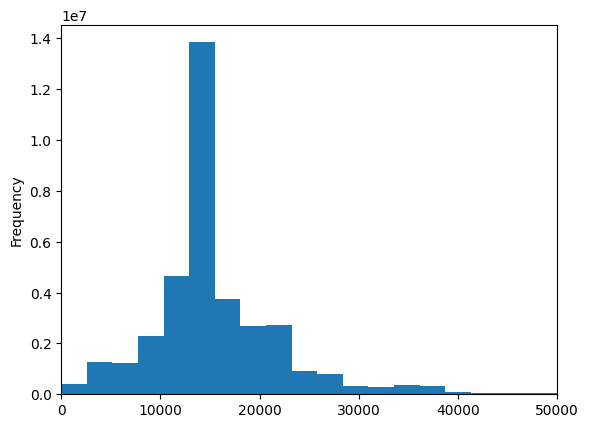

In [6]:
_ = df["SectorStartLag"].plot.hist(bins=100, xlim=(0, 50000))
df["SectorStartLag"].describe()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

<Axes: ylabel='Frequency'>

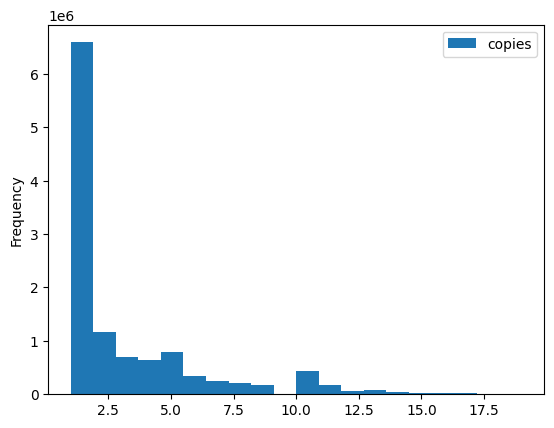

In [7]:
con.sql(
    """
    select
        PieceCID."/" as piece_id,
        count(*) as copies
    from state_market_deals
    where 1=1
        and SectorStartEpoch != -1
        and SlashEpoch = -1
    group by piece_id
    having copies < 20
    order by 2 desc
    """
).df().plot.hist(bins=20)


In [8]:
con.sql(
    """
    select
        PieceCID."/" as piece_id,
        count(*) as copies
    from state_market_deals
    where 1=1
        and SectorStartEpoch != -1
        and SlashEpoch = -1
    group by piece_id
    order by copies desc
    limit 5
    """
).df().values


array([['baga6ea4seaqof356aeq4mvurh43yir2z6j3wguczeke4dy4lngbb7fwrmfpjydy',
        10420],
       ['baga6ea4seaqnvexhndom5ipydpn42c3va2jhuepv4bc7rwrc33t3x7gqkn53ugi',
        8640],
       ['baga6ea4seaqma3d2foqh3obhlxca2z4emobsarysx5pyrygroakuyxyd7sjzmby',
        6518],
       ['baga6ea4seaqfecaafawnex4i4z3dlpv5ngaxp5sa5spgf77mz3s3lvfidqom2da',
        636],
       ['baga6ea4seaqootvvm3rolzm7o4cdbshrgs4ceoe5rdwi6j6q52gmmkgtppwiogq',
        631]], dtype=object)

In [9]:
con.sql(
    """
    select distinct
        Client,
        Provider,
    from state_market_deals
    where PieceCID."/" = 'baga6ea4seaqof356aeq4mvurh43yir2z6j3wguczeke4dy4lngbb7fwrmfpjydy'
    """
).df()


,Client,Provider
0,f01624861,f01781851
1,f01624861,f01716466
